In [1]:
MODEL_MESH_F = '/g/data/vk83/experiments/inputs/access-om3/share/meshes/global.1deg/2024.01.25/access-om2-1deg-ESMFmesh.nc'

In [2]:
TEMP_WEIGHTS_F = 'temp_weights.nc'

In [3]:
OUTPUT_F = '/g/data/tm70/as2285/payu/MOM6-CICE6/masked_rof_weights.nc'

In [4]:
import xarray as xr

import esmpy

import numpy as np

import matplotlib.pyplot as plt

from scipy.spatial import KDTree

from copy import copy

We need to generate remapping weights for use in the mediator, such that the overall volumne of runoff is conserved and no run-off is mapped onto land cells. Inside the mediator, the grid doesn't change as we run the mediator with the ocean grid (the DROF component remaps from JRA grid to mediator grid).

CMEPS only uses esmf files for grids/meshes, so we use the mediator mesh in this format:

In [5]:
model_mesh = esmpy.Mesh(
    filename= MODEL_MESH_F, 
    filetype=esmpy.FileFormat.ESMFMESH,
)

[gadi-cpu-clx-0438.gadi.nci.org.au:2350527] shmem: mmap: an error occurred while determining whether or not /jobfs/132027242.gadi-pbs/ompi.gadi-cpu-clx-0438.17287/jf.0/3708157952/shared_mem_cuda_pool.gadi-cpu-clx-0438 could be created.
[gadi-cpu-clx-0438.gadi.nci.org.au:2350527] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [6]:
model_mesh

Mesh:
    rank = 1
    size = [108071, 108000]
    size_owned = [108071, 108000]
    coords = [[array([ 80.,  81.,  81., ..., 260., 260., 260.]), array([-78.        , -78.        , -77.75316839, ...,  66.23869773,
        65.83214327,  65.41931068])], [array([80.5       , 81.5       , 82.5       , ..., 79.95558838,
       79.97336385, 79.99112309]), array([-77.87662338, -77.87662338, -77.87662338, ...,  66.03603278,
        65.62642645,  65.21044485])]]

Mesh files contain nodes and elements, run-off is a grid cell average, so we want the elements. The mediator is not changing grids, so the mesh is the same for both fields. We need to make ESMF fields to generate remapping weights, (which are all unity):

In [7]:
med_in_fld = esmpy.Field(
    model_mesh,
    meshloc=esmpy.MeshLoc.ELEMENT
)

In [8]:
med_out_fld = esmpy.Field(
    model_mesh,
    meshloc=esmpy.MeshLoc.ELEMENT
)

Generate weights

In [9]:
rm {TEMP_WEIGHTS_F}

In [10]:
regridder = esmpy.Regrid(
    med_in_fld, med_out_fld, 
    filename = TEMP_WEIGHTS_F ,
    regrid_method=esmpy.RegridMethod.CONSERVE,
    # unmapped_action=esmpy.UnmappedAction.ERROR, #ignore errors about some destination cells not having source cells,
)

Set the incoming runoff to unity everywhere and confirm that nothing happens:

In [11]:
med_in_fld.data[:]=1

In [12]:
regridder(med_in_fld, med_out_fld)

Field:
    name = None
    type = <TypeKind.R8: 6>
    rank = 1
    extra dimensions = 0
    staggerloc = 1
    lower bounds = array([0], dtype=int32)
    upper bounds = array([108000], dtype=int32)
    extra bounds = None
    data = array([1., 1., 1., ..., 1., 1., 1.])
    grid = 
Mesh:
    rank = 1
    size = [108071, 108000]
    size_owned = [108071, 108000]
    coords = [[array([ 80.,  81.,  81., ..., 260., 260., 260.]), array([-78.        , -78.        , -77.75316839, ...,  66.23869773,
        65.83214327,  65.41931068])], [array([80.5       , 81.5       , 82.5       , ..., 79.95558838,
       79.97336385, 79.99112309]), array([-77.87662338, -77.87662338, -77.87662338, ...,  66.03603278,
        65.62642645,  65.21044485])]]

)

In [13]:
med_out_fld.data

array([1., 1., 1., ..., 1., 1., 1.])

In [14]:
assert all(med_in_fld.data == med_out_fld.data)

Now we have a template weight file, we can adjust for the land mask:

In [15]:
weights_ds = xr.open_dataset(TEMP_WEIGHTS_F)

In [16]:
weights_ds

<xarray.Dataset> Size: 2MB
Dimensions:  (n_s: 108000)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 864kB ...
    col      (n_s) int32 432kB ...
    row      (n_s) int32 432kB ...

Per the above note, we want to adjust all row values, so they are ocean cells. When we do this, we want to adjust S, the weight to account for the difference in area.

Open the mesh file directly to get the mask

In [17]:
mod_mesh_ds = xr.open_dataset(MODEL_MESH_F)

In [18]:
mod_mesh_ds

<xarray.Dataset> Size: 7MB
Dimensions:         (nodeCount: 108071, coordDim: 2, elementCount: 108000,
                     maxNodePElement: 4)
Dimensions without coordinates: nodeCount, coordDim, elementCount,
                                maxNodePElement
Data variables:
    nodeCoords      (nodeCount, coordDim) float64 2MB ...
    elementConn     (elementCount, maxNodePElement) int32 2MB ...
    numElementConn  (elementCount) int32 432kB ...
    centerCoords    (elementCount, coordDim) float64 2MB ...
    elementMask     (elementCount) int8 108kB ...
    elementArea     (elementCount) float64 864kB ...
Attributes:
    gridType:       unstructured mesh
    timeGenerated:  2024-01-25 15:01:40.899669
    created_by:     ds0092
    inputFile:      /g/data/ik11/inputs/access-om2/input_20201102/mom_1deg/oc...
    history:        Created using commit 7b06e94dc79684c8e5b0d33a36d8046d42e9...

Find index for all ocean cells:

In [19]:
mask_i = mod_mesh_ds.elementCount.where(mod_mesh_ds.elementMask, drop=True).astype('int64')

Make a KDTree from the coordinates of each element which is an ocean cell.

In [20]:
mask_tree = KDTree(
    mod_mesh_ds.centerCoords.isel(elementCount = mask_i)
)

Using the KDTree, look up the nearest ocean cell to every destination grid cell in our weights file.
Note our weights are indexed from 1 (i.e. Fortran style) but xarray starts from 0 (i.e. python style), so subract one from our desitination grid cell indices.

In [21]:
dd, ii = mask_tree.query(
    mod_mesh_ds.centerCoords.isel(elementCount=(weights_ds.row-1)),
    workers = -1
)

ii is the index of ocean grid cells to be mapped to, however its the index of the list the KDTree is built on (i.e. relative to ```python mod_mesh_ds.centerCoords.isel(elementCount = mask_i)``` )

In [22]:
new_row = (mask_i[ii]+1)

Get the mesh element areas:
n.b. per CMEPS we are using the internally calculated areas, not the user provided ones. (These should be identical, based on the area of the surface of a sphere,  as long as the Earth's radius is consistent between CMEPS and MOM6).

In [23]:
med_out_fld.get_area()

area = copy(med_out_fld.data)

In [24]:
old_area = area[weights_ds.row-1]

In [25]:
new_area = area[new_row-1]

In [26]:
area_cor = old_area/new_area

In [27]:
weights_ds['row'] = xr.DataArray(
    data=new_row,
    dims='n_s'
)

In [28]:
weights_ds['S'] = weights_ds.S*area_cor

In [29]:
weights_ds.row

<xarray.DataArray 'row' (n_s: 108000)> Size: 864kB
array([ 10078,  10078,  10078, ..., 107980, 107980, 107980])
Dimensions without coordinates: n_s

In [30]:
weights_ds.S

<xarray.DataArray 'S' (n_s: 108000)> Size: 864kB
array([0.31697789, 0.31697789, 0.31697789, ..., 0.19972566, 0.12345803,
       0.04223369])
Dimensions without coordinates: n_s

In [31]:
rm {OUTPUT_F}

In [32]:
weights_ds.to_netcdf(OUTPUT_F)

Sanity check out new weights, with unity input again:

In [33]:
med_in_fld.data[:]=1

In [34]:
med_in_fld

Field:
    name = None
    type = <TypeKind.R8: 6>
    rank = 1
    extra dimensions = 0
    staggerloc = 1
    lower bounds = array([0], dtype=int32)
    upper bounds = array([108000], dtype=int32)
    extra bounds = None
    data = array([1., 1., 1., ..., 1., 1., 1.])
    grid = 
Mesh:
    rank = 1
    size = [108071, 108000]
    size_owned = [108071, 108000]
    coords = [[array([ 80.,  81.,  81., ..., 260., 260., 260.]), array([-78.        , -78.        , -77.75316839, ...,  66.23869773,
        65.83214327,  65.41931068])], [array([80.5       , 81.5       , 82.5       , ..., 79.95558838,
       79.97336385, 79.99112309]), array([-77.87662338, -77.87662338, -77.87662338, ...,  66.03603278,
        65.62642645,  65.21044485])]]

)

In [35]:
new_regridder = esmpy.RegridFromFile(
    med_in_fld, med_out_fld, 
    filename = OUTPUT_F ,
    # regrid_method=esmpy.RegridMethod.BILINEAR,
    # unmapped_action=esmpy.UnmappedAction.IGNORE, #ignore errors about some destination cells not having source cells,
)

In [36]:
med_out_fld

Field:
    name = None
    type = <TypeKind.R8: 6>
    rank = 1
    extra dimensions = 0
    staggerloc = 1
    lower bounds = array([0], dtype=int32)
    upper bounds = array([108000], dtype=int32)
    extra bounds = None
    data = array([1.57903375e-05, 1.57903375e-05, 1.57903375e-05, ...,
       4.45742961e-06, 2.75530699e-06, 9.42561450e-07])
    grid = 
Mesh:
    rank = 1
    size = [108071, 108000]
    size_owned = [108071, 108000]
    coords = [[array([ 80.,  81.,  81., ..., 260., 260., 260.]), array([-78.        , -78.        , -77.75316839, ...,  66.23869773,
        65.83214327,  65.41931068])], [array([80.5       , 81.5       , 82.5       , ..., 79.95558838,
       79.97336385, 79.99112309]), array([-77.87662338, -77.87662338, -77.87662338, ...,  66.03603278,
        65.62642645,  65.21044485])]]

)

In [37]:
new_regridder(med_in_fld, med_out_fld)

Field:
    name = None
    type = <TypeKind.R8: 6>
    rank = 1
    extra dimensions = 0
    staggerloc = 1
    lower bounds = array([0], dtype=int32)
    upper bounds = array([108000], dtype=int32)
    extra bounds = None
    data = array([0., 0., 0., ..., 0., 0., 0.])
    grid = 
Mesh:
    rank = 1
    size = [108071, 108000]
    size_owned = [108071, 108000]
    coords = [[array([ 80.,  81.,  81., ..., 260., 260., 260.]), array([-78.        , -78.        , -77.75316839, ...,  66.23869773,
        65.83214327,  65.41931068])], [array([80.5       , 81.5       , 82.5       , ..., 79.95558838,
       79.97336385, 79.99112309]), array([-77.87662338, -77.87662338, -77.87662338, ...,  66.03603278,
        65.62642645,  65.21044485])]]

)

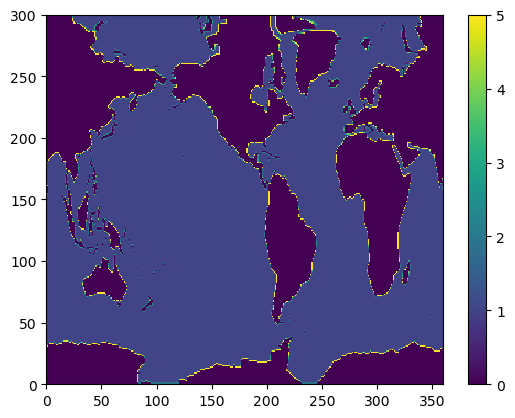

In [38]:
plt.pcolor(np.reshape(med_out_fld.data,(300,360)), vmax=5)
plt.colorbar()

In [39]:
sum(med_in_fld.data)

108000.0

In [40]:
sum(med_out_fld.data)

110021.44810549436

In [41]:
sum(med_in_fld.data*area)

12.429074684245569

In [42]:
sum(med_out_fld.data*area)

12.429074684243966

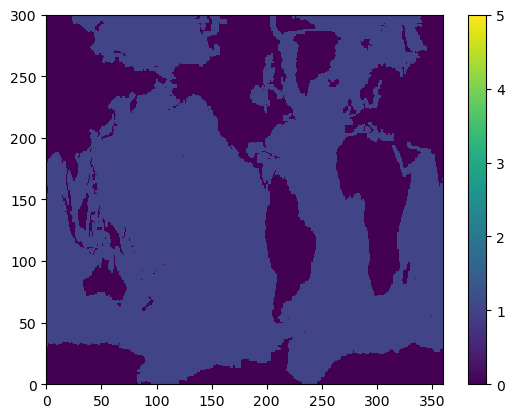

In [43]:
plt.pcolor(np.reshape(mod_mesh_ds.elementMask.values,(300,360)), vmax=5)
plt.colorbar()

Confirm that no everywhere runoff is non-zero is ocean:

In [44]:
assert all((med_out_fld.data!=0).astype(int)==mod_mesh_ds.elementMask)